# Music genre analysis
This notebook is the training of a model to classify the song genre. We use the dataset from FMA. Please refer to https://github.com/mdeff/fma
to download the dataset and for further instructions.

In this notebook, we'll use fastai for training.

Install neccesary libraries

In [ ]:
!pip install python-dotenv
!pip install pydot
!pip install fastaudio

# 1. Preparing Dataset
First we'll git clone the repository, download the dataset and unzip it. We will download the medium dataset for training

In [1]:
!git clone https://github.com/mdeff/fma.git
!cd fma

Cloning into 'fma'...
remote: Enumerating objects: 823, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 823 (delta 6), reused 12 (delta 4), pack-reused 808
Receiving objects: 100% (823/823), 4.08 MiB | 7.14 MiB/s, done.
Resolving deltas: 100% (528/528), done.


The following block is to download the dataset, unzip and save to my personal google drive. Please refer to https://github.com/mdeff/fma for more info

In [ ]:
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!curl -O https://os.unil.cloud.switch.ch/fma/fma_medium.zip

!echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  fma_metadata.zip" | sha1sum -c -
!echo "c67b69ea232021025fca9231fc1c7c1a063ab50b  fma_medium.zip"   | sha1sum -c -

#unzip the datasets and save to my google drive
!7z x fma_metadata.zip -o"/content/drive/MyDrive/Colab Notebooks/Music_model_2"
!7z x fma_medium.zip -o"/content/drive/MyDrive/Colab Notebooks/Music_model_2"

!rm -r fma_metadata.zip
!rm -r fma_medium.zip

In [1]:
import os
import subprocess

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

import librosa

import sys
sys.path.insert(1, '/content/fma')
import utils

from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci


/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


We'll use the util function provided to load the dataset as stated in the instructions in the repository

In [3]:
tracks_path = '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_metadata/tracks.csv'
tracks = utils.load(tracks_path)
tracks.shape

(106574, 52)

We will only select the rows for songs in medium dataset

In [4]:
df = tracks.copy()
df.columns = df.columns.get_level_values(1)
medium_df = df[df['subset'] <= 'medium']

# 2. Data Cleansing

We'll then get all the paths for the songs using the util functions provided, and then put it back in the dataframe.

In [5]:
index_list = medium_df.index.to_list()
path_list = [str(utils.get_audio_path('/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium', x))[0:] for x in index_list]
medium_df['path'] = path_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Here are the error files which have problems in playing, we will exclude those files in the dataframe for further training.

In [6]:
# These are the audio files which have problems and can't be played
error_file = [
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/001/001486.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/005/005574.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/065/065753.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/080/080391.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/098/098558.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/098/098559.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/098/098560.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/098/098571.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/099/099134.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/105/105247.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/108/108925.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/126/126981.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/127/127336.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/133/133297.mp3',
      '/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/143/143992.mp3',
      ]


In [7]:
medium_df = medium_df[~medium_df['path'].isin(error_file)]

Select only `path` and `genre_top` for metadata, since these are the 2 things we need for training

In [8]:
medium_df = medium_df[['path','genre_top']]
medium_df.reset_index(inplace=True)

# 3. Preprocessing

We'll now encode the `genre` as target using `LabelEncoder()` from `sklearn`

In [9]:
le = LabelEncoder()
medium_df['genre'] = le.fit_transform(medium_df['genre_top'])

In [10]:
# To view the encoded class list
class_list = le.classes_
class_list

array(['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic',
       'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International',
       'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken'],
      dtype=object)

Let's view the dataframe we obtained before we train the model.

In [11]:
medium_df.sample(10)

,track_id,path,genre_top,genre
2191,13563,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/013/013563.mp3,Rock,13
13730,84538,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/084/084538.mp3,Experimental,5
2674,15964,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/015/015964.mp3,Electronic,4
20518,126625,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/126/126625.mp3,Electronic,4
23020,140005,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/140/140005.mp3,Electronic,4
19085,120314,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/120/120314.mp3,Instrumental,8
18086,114374,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/114/114374.mp3,Instrumental,8
11989,71878,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/071/071878.mp3,Instrumental,8
5403,33220,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/033/033220.mp3,Electronic,4
17780,113165,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/113/113165.mp3,Rock,13


For the first training, I selected a much smaller dataset for training. After ensuring everything is fine, we can then train the model with the whole dataset

In [12]:
# Select first 1000 songs for the small dataset
sample_df = medium_df.copy()
sample_df = sample_df.head(1000).reset_index()
sample_df['genre'] = LabelEncoder().fit_transform(sample_df.genre_top.values)
sample_df

,index,track_id,path,genre_top,genre
0,0,2,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/000/000002.mp3,Hip-Hop,6
1,1,3,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/000/000003.mp3,Hip-Hop,6
2,2,5,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/000/000005.mp3,Hip-Hop,6
3,3,10,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/000/000010.mp3,Pop,10
4,4,134,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/000/000134.mp3,Hip-Hop,6
...,...,...,...,...,...
995,995,6358,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/006/006358.mp3,International,7
996,996,6360,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/006/006360.mp3,International,7
997,997,6363,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/006/006363.mp3,International,7
998,998,6366,/content/drive/MyDrive/Colab Notebooks/Music_model_2/fma_medium/006/006366.mp3,International,7


# 4. Data Augmentation

We will now set up some configs for training, and we will cut our songs to 25s, since most of the songs are not 30s long.

In [13]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
crop1s = ResizeSignal(25000)
a2s = AudioToSpec.from_cfg(cfg)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


# 5. Model Training

Given the GPU limit of the colab notebook, we will separate the training epochs. We will save the previous models trained, and load them back and train them in separate times.

Here I use a pretrained model Resnet18 for transfer learning, I will make some fine-tune on it during the training.

In [14]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("path"),
                 splitter = RandomSplitter(),
                 item_tfms = [crop1s],
                 batch_tfms = [a2s],
                 get_y = ColReader("genre"))

In [15]:
dbunch = auds.dataloaders(medium_df, bs=64)

In [16]:
#Setting up callbacks
early_stopping_callback = EarlyStoppingCallback(min_delta=0.01, patience=1)
save_model_callback = SaveModelCallback(every_epoch=True, with_opt=True)
reduce_lr = ReduceLROnPlateau(min_delta=0.01, patience=1, factor=10.0, min_lr=1e-7) 
cbs = [early_stopping_callback, save_model_callback, reduce_lr]

In [17]:
learn = cnn_learner(dbunch, 
            resnet18,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            cbs = cbs,
            metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.001737800776027143)

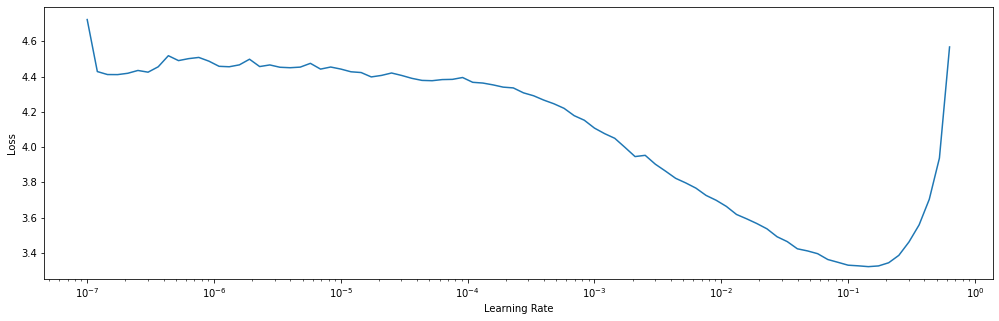

In [ ]:
learn.lr_find()

Since the `lr_steep` is 0.0017, we'll set our learning rate to 0.002

Given the GPU usage limit by Google colab, we have to train the model separately in a few times. In the following, we have a function to train the model and save it for future training

In [ ]:
def train_learner(num_epochs, lr=0.002, retrain_model=False):
  pre_trained_model_path = '/content/drive/MyDrive/Colab Notebooks/Music_model_2/trained_learn'
  if retrain_model:
    global learn
    learn = learn.load(pre_trained_model_path)
  learn.fine_tune(num_epochs, lr)
  learn.save(pre_trained_model_path)


**1st and 2nd epoch of training**

In [ ]:
train_learner(num_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,1.702061,1.319106,0.625976,1:48:10


epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,1.175624,1.072660,0.677406,1:46:54


**3rd and 4th epoch of training**

In [ ]:
train_learner(num_epochs=1, retrain_model=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.118485,1.015314,0.691215,1:56:56


epoch,train_loss,valid_loss,accuracy,time
0,1.027204,0.944274,0.709626,1:58:00


**5th and 6th epoch of training**
Given the reducing loss decrease, in the 5th epoch, I reduce the learning rate to 1e-7.
For the 6th epoch, the loss kept increasing, for the sake of time and the connection loss in colab, I stopped the training.

In [ ]:
train_learner(num_epochs=1, lr=1e-7, retrain_model=True)

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.946788,0.837109,0.737643,2:37:15


epoch,train_loss,valid_loss,accuracy,time


# 6. Result Evaluation

In [18]:
pre_trained_model_path = '/content/drive/MyDrive/Colab Notebooks/Music_model_2/model_0'
learn = learn.load(pre_trained_model_path)

In [ ]:
preds, target = learn.get_preds()

In [ ]:
y_preds = np.argmax(preds, axis=-1)

In [ ]:
print('Accuracy: ', accuracy_score(target, y_preds))
print(classification_report(target, y_preds, target_names=class_list))

Accuracy:  0.729037422453472
                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        19
          Classical       0.78      0.81      0.80       126
            Country       0.17      0.02      0.04        41
     Easy Listening       0.00      0.00      0.00         4
         Electronic       0.73      0.87      0.79      1297
       Experimental       0.61      0.55      0.58       422
               Folk       0.62      0.74      0.67       299
            Hip-Hop       0.84      0.76      0.79       413
       Instrumental       0.54      0.40      0.46       273
      International       0.66      0.61      0.63       199
               Jazz       0.56      0.46      0.51        69
Old-Time / Historic       0.99      0.99      0.99       114
                Pop       0.50      0.09      0.15       252
               Rock       0.79      0.87      0.83      1413
           Soul-RnB       0.50      0.09      0.15     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


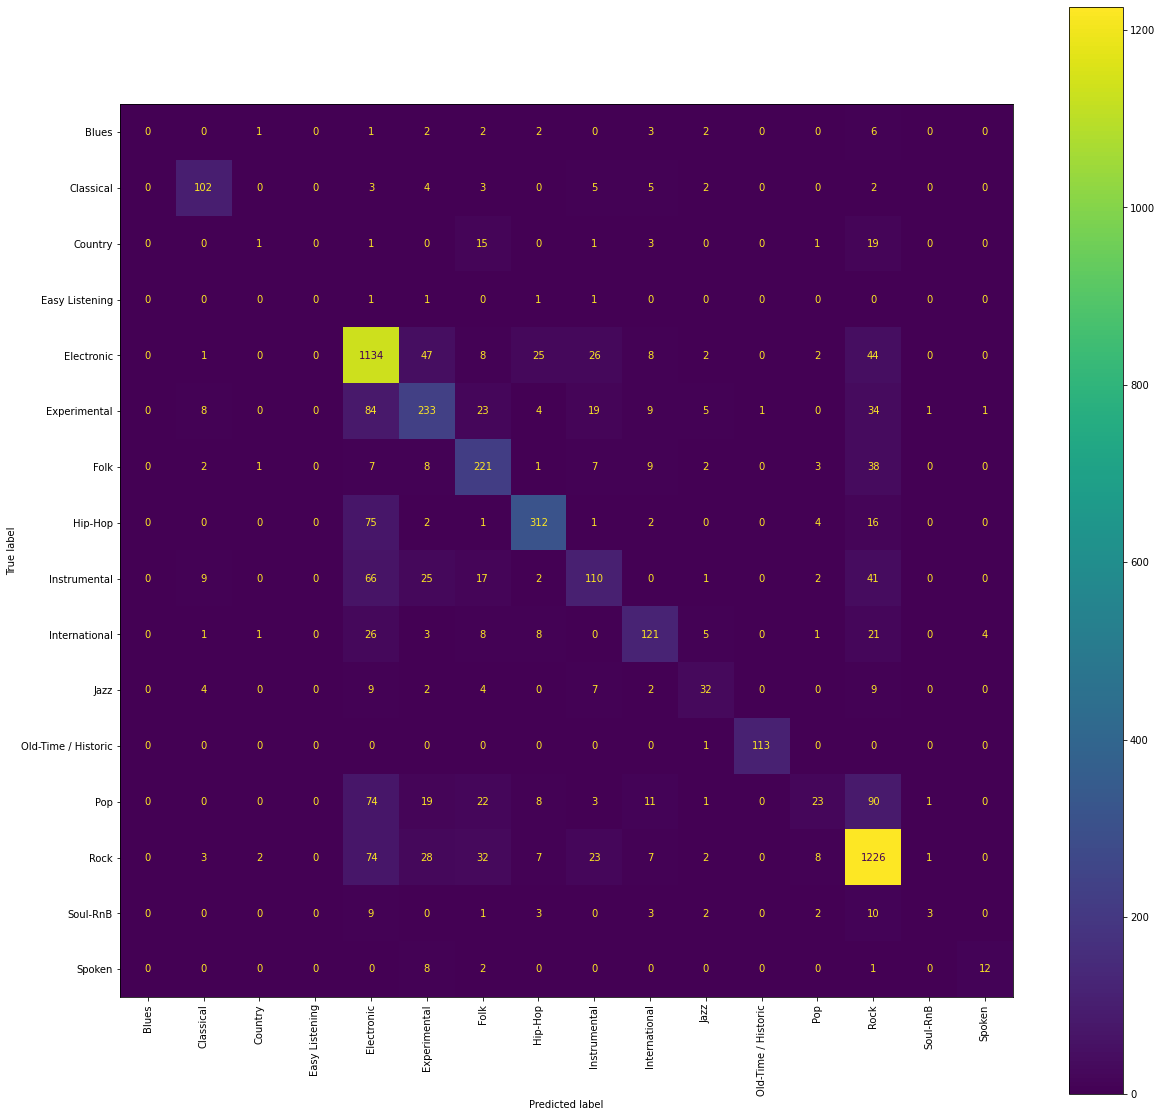

In [ ]:
ConfusionMatrixDisplay.from_predictions(target, y_preds, display_labels=list(class_list),xticks_rotation='vertical')

From the above, we may see that the model has a fair overall accuracy of 73%, and did a pretty good job in classifying rock, electronic, and hip hop music. However, some of the genres are pretty hard for the model to learn. 
This may be due to the quality of the data.
According to the previous training done by the others (https://nbviewer.org/github/mdeff/fma/blob/outputs/baselines.ipynb),
the base line is 17.6%, which means this model always performs very well.

Export learner for predicting new data

In [19]:
learn.export(fname='/content/drive/MyDrive/Colab Notebooks/Music_model_2/learner.pkl')